# Check linearity

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from itertools import product
import numpy as np
import xarray as xr
import dask

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import cmocean

import box_model
import util

Set ocean state

In [3]:

dic_range = np.arange(1900.0, 2300.0, 10.0)
alk_range = np.arange(2300.0, 2550.0, 10.0)
delta_alk_range = np.arange(50.0, 750.0, 50.0)

ni = len(alk_range)
nj = len(dic_range)
nk = len(delta_alk_range)

coords = dict(
    dic=xr.DataArray(dic_range, name='dic', dims=('dic')),
    alk=xr.DataArray(alk_range, name='alk', dims=('alk')),
    delta_alk=xr.DataArray(delta_alk_range, name='delta_alk', dims=('delta_alk')),
)

ds = xr.Dataset(
    data_vars=dict(
        eta=xr.DataArray(np.empty((nk, nj, ni)), name='eta', dims=('delta_alk', 'dic', 'alk')),
        ddicdco2=xr.DataArray(np.empty((nk, nj, ni)), name='ddicdco2', dims=('delta_alk', 'dic', 'alk')), 
        dtau_dalk=xr.DataArray(np.empty((nj, ni)), name='dtau_dalk', dims=('dic', 'alk')), 
        deta_dalk=xr.DataArray(np.empty((nj, ni)), name='deta_dalk', dims=('dic', 'alk')),
    ),
    coords=coords,
)
ds

<xarray.Dataset> Size: 241kB
Dimensions:    (dic: 40, alk: 25, delta_alk: 14)
Coordinates:
  * dic        (dic) float64 320B 1.9e+03 1.91e+03 ... 2.28e+03 2.29e+03
  * alk        (alk) float64 200B 2.3e+03 2.31e+03 ... 2.53e+03 2.54e+03
  * delta_alk  (delta_alk) float64 112B 50.0 100.0 150.0 ... 600.0 650.0 700.0
Data variables:
    eta        (delta_alk, dic, alk) float64 112kB 1.154e-310 1.154e-310 ... 0.0
    ddicdco2   (delta_alk, dic, alk) float64 112kB 1.154e-310 1.154e-310 ... 0.0
    dtau_dalk  (dic, alk) float64 8kB 1.154e-310 1.154e-310 ... 2.626e-316
    deta_dalk  (dic, alk) float64 8kB 1.154e-310 1.154e-310 ... 4.447e-323

In [4]:
cluster, client = util.get_ClusterClient(memory='12GB')
cluster.scale(128)
client

/glade/work/mclong/miniconda3/envs/mcdr-atlas/lib/python3.10/site-packages/dask_jobqueue/pbs.py:82: FutureWarning: project has been renamed to account as this kwarg was used wit -A option. You are still using it (please also check config files). If you did not set account yet, project will be respected for now, but it will be removed in a future release. If you already set account, project is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/glade/work/mclong/miniconda3/envs/mcdr-atlas/lib/python3.10/site-packages/dask_jobqueue/pbs.py:82: FutureWarning: project has been renamed to account as this kwarg was used wit -A option. You are still using it (please also check config files). If you did not set account yet, project will be respected for now, but it will be removed in a future release. If you already set account, project is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)


Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.65:37029,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [5]:
obj = box_model.calc_csys(dic_range[0], alk_range[0], salt=35.0, temp=20.0)


@dask.delayed
def compute_eta(dic, alk, delta_alk):
    obj.solve_co2(dic, alk)
    delta_dic = obj.calc_new_dic_w_oae(alk + delta_alk) - dic
    return delta_dic / delta_alk, obj.ddicdco2(alk + delta_alk)

del_objs = []
for k, delta_alk in enumerate(delta_alk_range):
    for j, dic in enumerate(dic_range):
        for i, alk in enumerate(alk_range):
            del_objs.append(compute_eta(dic, alk, delta_alk))

computed_objs = dask.compute(*del_objs)

n = 0
for k, delta_alk in enumerate(delta_alk_range):
    for j, dic in enumerate(dic_range):
        for i, alk in enumerate(alk_range):
            eta, ddicdco2 = computed_objs[n]
            ds.eta[k, j, i] = eta
            ds.ddicdco2[k, j, i] = ddicdco2

            n += 1

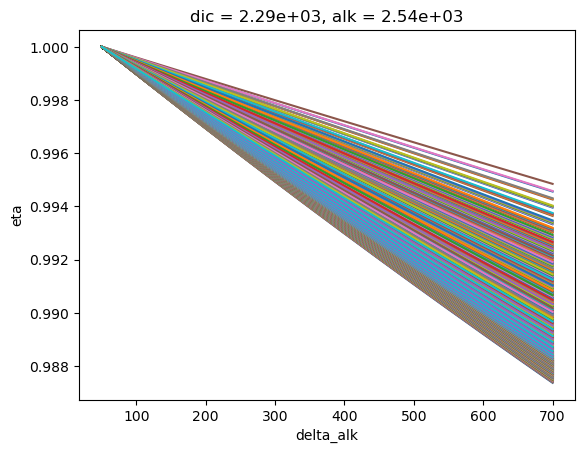

In [6]:
for j, dic in enumerate(dic_range):
    for i, alk in enumerate(alk_range):
        (ds.eta.isel(dic=j, alk=i) / ds.eta.isel(delta_alk=0, dic=j, alk=i)).plot()

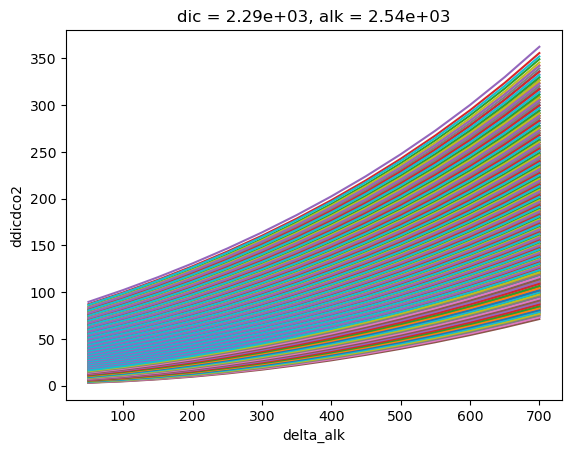

In [7]:
for j, dic in enumerate(dic_range):
    for i, alk in enumerate(alk_range):
        (ds.ddicdco2.isel(dic=j, alk=i)).plot()

In [8]:
for j, dic in enumerate(dic_range):
    for i, alk in enumerate(alk_range):
        m, b  = np.polyfit(ds.delta_alk, ds.eta.isel(dic=j, alk=i), 1)
        ds.deta_dalk[j, i] = 100.0 * m

In [9]:
for j, dic in enumerate(dic_range):
    for i, alk in enumerate(alk_range):
        m, b  = np.polyfit(ds.delta_alk, ds.ddicdco2.isel(dic=j, alk=i) / ds.ddicdco2.isel(delta_alk=0, dic=j, alk=i), 1)
        ds.dtau_dalk[j, i] = 100.0 * m


Text(0, 0.5, 'DIC [mmol m$^{-3}$]')

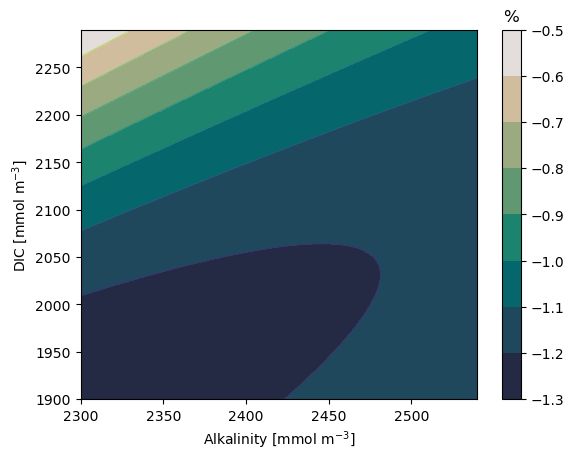

In [10]:
cf = plt.contourf(
    ds.alk, ds.dic, 100 * (ds.eta[-1, :, :] - ds.eta[0, :, :]) / ds.eta[0, :, :],
    cmap=cmocean.cm.rain_r,
)
plt.contour(
    ds.alk, ds.dic, 100 * (ds.eta[-1, :, :] - ds.eta[0, :, :]) / ds.eta[0, :, :],
    linewidths=0.5
)
cb = plt.colorbar(cf)
cb.ax.set_title('%')
plt.xlabel('Alkalinity [mmol m$^{-3}$]')
plt.ylabel('DIC [mmol m$^{-3}$]')



Text(0.5, 1.0, 'Change in $\\eta_{max}$ with ∆Alk')

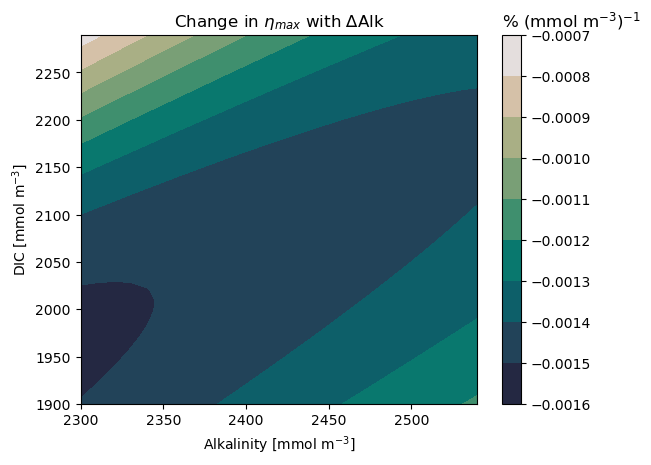

In [11]:
cf = plt.contourf(
    ds.alk, ds.dic, ds.deta_dalk,
    cmap=cmocean.cm.rain_r,
)
cb = plt.colorbar(cf)
cb.ax.set_title('% (mmol m$^{-3}$)$^{-1}$', loc='left')
plt.xlabel('Alkalinity [mmol m$^{-3}$]')
plt.ylabel('DIC [mmol m$^{-3}$]')
plt.title('Change in $\eta_{max}$ with ∆Alk')

Text(0.5, 1.0, 'Change in $\\tau_{gas}$ with ∆Alk')

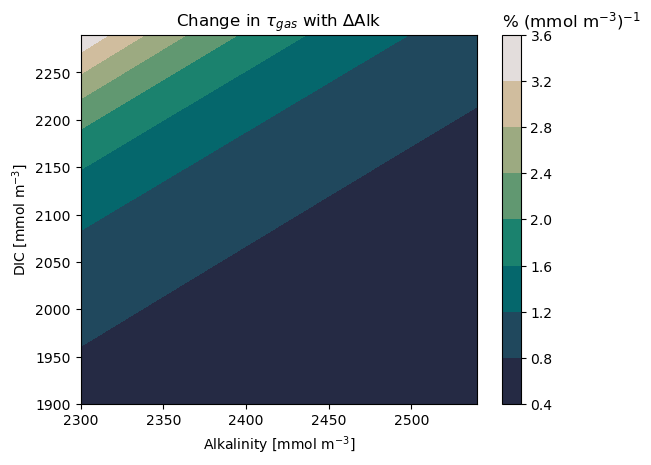

In [13]:
cf = plt.contourf(
    ds.alk, ds.dic, ds.dtau_dalk,
    cmap=cmocean.cm.rain_r,
)
cb = plt.colorbar(cf)
cb.ax.set_title('% (mmol m$^{-3}$)$^{-1}$', loc='left')
plt.xlabel('Alkalinity [mmol m$^{-3}$]')
plt.ylabel('DIC [mmol m$^{-3}$]')
plt.title('Change in $\\tau_{gas}$ with ∆Alk')

In [14]:
del client
del cluster